# Lab 4 - DeepONets
DeepONets are neural network architectures designed to learn operators (i.e., mappings between functions). Consider the one dimensional boundary value problem
$$
\begin{aligned}
\nabla\cdot\left(a\nabla u^a\right) &= f \quad \text{in } (0,1)=:\Omega\\
u(0) = u(1) &= 0.
\end{aligned}
$$
For some value $a_{\min{}}$, we define the admissible data set 
$$
\mathcal{A} = \left\{a\in L^\infty(\Omega) : a(x)\geq a_{\min{}}\text{ almost everywhere}\right\}
$$
and the solution operator 
$$
\mathcal{S}:
\begin{cases} \mathcal{A} \to H^1_0(\Omega)\\
a\mapsto u^a.
\end{cases}
$$
We want to approximate the operator $\mathcal{S}$ over some set $\mathcal{D}\subset\mathcal{A}$ with a deepONet $\mathcal{G}$.



In [102]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from DNN import DeepNet 
from utilities import plot_data, plot_results, LprelLoss

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.set_default_dtype(torch.float64)

# Data Loading
We fix $f=1$ and consider the data set
$$
\mathcal{D} = \left\{ a(x) = 1+\sum_{i=1}^3 y_i \mathbb{1}_{((i-1)/3, i/3)}(x): y_i\in (0,8)\right\}
$$
And solve the problem with linear finite elements. The code to solve the problem is given in the files `FEsolver.py` and `data_gen.ipynb`, though these require installing `FEniCSx`. To use the data, you can also load it from the respective files, that contain
- coordinates $x_1, \dots, x_M$
- coefficient values $a(x_1), \dots, a(x_M)$
- solution values $u(x_1), \dots, u(x_M)$
- solution gradient $u'(x_1), \dots, u'(x_M)$.

In [103]:
x = torch.load("data/x_train.pt")
coefs = torch.load("data/a_train.pt")
solutions = torch.load("data/u_train.pt")
grad_solutions = torch.load("data/gradu_train.pt")

# check the dimension of the data
print("Dimension of x: ", x.shape)
print("Dimension of coefs: ", coefs.shape)
print("Dimension of solutions: ", solutions.shape)
print("Dimension of gradients of solutions: ", grad_solutions.shape)

Dimension of x:  torch.Size([64])
Dimension of coefs:  torch.Size([250, 64])
Dimension of solutions:  torch.Size([250, 64])
Dimension of gradients of solutions:  torch.Size([250, 64])


# Plot some input-output pairs
Use the function `plot_data` provided in `utilities.py` to plot some $(a, \mathcal{S}(a))$ pairs.

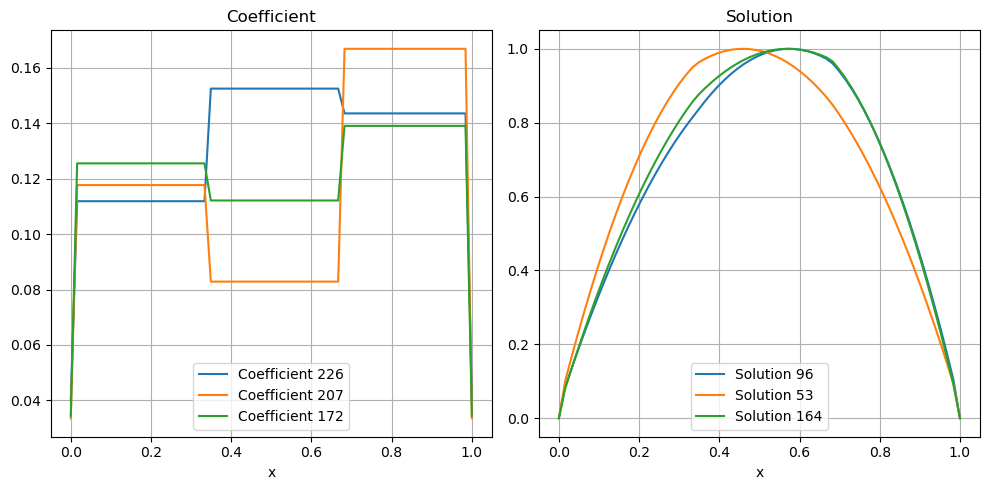

In [104]:
plot_data(x, {'Coefficient': coefs, 'Solution': solutions}, num_samples_to_plot=3)

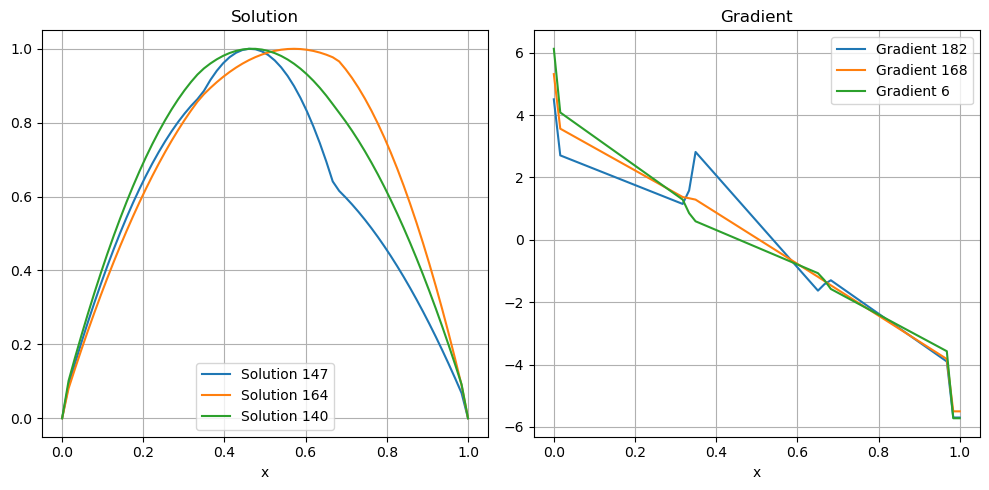

In [105]:
plot_data(x, {'Solution': solutions, 'Gradient': grad_solutions}, num_samples_to_plot=3)

# DeepONet architecture
We now define the `DeepONet` class. We will use the `DeepNet` class that we have used in the previous labs.
A deep operator network is composed of
- a neural network $\Phi_{\mathrm{app}} : \mathbb{R}^M\to \mathbb{R}^N$ (branch network)
- a neural network $\Phi_{\mathrm{dec}} : \mathbb{R}^d \to \mathbb{R}^N$ (trunk network)

The `forward` function will take as input a point $x\in\mathbb{R^d}$ and a vector $a_1, \dots a_M \in \mathbb{R}^M$ and return
$$
\mathcal{G}(\mathcal{E}(a))(x) = \Phi_{\mathrm{app}}(a_1, \dots, a_M) \cdot \Phi_{\mathrm{dec}}(x)
$$
An implementation detail: we want to be able to evaluate on multiple points at once: the function above should be implemented so that if instead of a single point $x$ we have $\mathbf{x} = [x_1, \dots, x_p]^\top$, the function above should return
$$
\Big(\Phi_{\mathrm{app}}(a_1, \dots, a_M) \cdot \Phi_{\mathrm{dec}}(x_i)\Big)_{i=1}^p.
$$
The function takes as input the activation functions, the dimensions $M$, $d$, the widths of the layers, the dimension $N$, and a flag `bc`. If the flag is set to `True` the forward function above is replaced by
$$
\Phi_{\mathrm{app}}(a_1, \dots, a_M) \cdot \big(x(1-x)\Phi_{\mathrm{dec}}(x)\big)
$$
so that the boundary conditions are automatically satisfied.

We will also define a class method `grad_forward` that computes the derivative
$$
\Big(\nabla_x \mathcal{G}(\mathcal{E}(a))\Big)(x) = \Phi_{\mathrm{app}}(a_1, \dots, a_M) \cdot \Big(\nabla_x\Phi_{\mathrm{dec}}\Big)(x)
$$
Note that this function is not used for the training, but only to inspect the results. You can postpone its implementation (and comment the corresponding part of the code in the next sections).

In [106]:
# Device configuration
device = torch.device("cpu")
torch.set_default_device(device)

class DeepONet(nn.Module):
    def __init__(self, activation_branch, activation_trunk, branch_input_dim:int, trunk_input_dim:int, 
                 branch_hidden_dims:list, trunk_hidden_dims:list, num_basis:int, bc:bool=False):
        """
        DeepONet class. This class defines the architecture of the DeepONet.
        The DeepONet is composed of two subnetworks: the branch network and the trunk network.
        
        Args:
        activation: activation function
        branch_input_dim: input dimension of the branch network
        trunk_input_dim: input dimension of the trunk network
        branch_hidden_dims: list of the hidden dimensions of the branch network
        trunck_hidden_dims: list of the hidden dimensions of the trunk network
        num_basis: number of basis functions
        bc: boolean, if True, we multiply the output of the trunk network by x*(1-x) to satisfy the boundary condition
        """
        super(DeepONet, self).__init__()

        # The output dimension of the trunk network must be equal to the number of basis functions.
        assert trunk_hidden_dims[-1] == num_basis 

        self.activation_branch = activation_branch
        self.activation_trunk = activation_trunk
        self.bc = bc
        self.branch_net = DeepNet(activation_branch, branch_input_dim, branch_hidden_dims, num_basis)
        self.trunk_net = DeepNet(activation_trunk, trunk_input_dim, trunk_hidden_dims, None)        

    def forward(self, f_branch, x_trunk):
        branch_output = self.branch_net(f_branch)
        trunk_output = self.trunk_net(x_trunk)

        if self.bc:
            trunk_output = trunk_output.T * x_trunk[:] * (x_trunk[:] - 1.0)
            return branch_output @ trunk_output
        else:
            return branch_output @ trunk_output.T

    def grad_forward(self, f_branch, x_trunk):
        x_trunk.requires_grad_(True)
        branch_output = self.branch_net(f_branch)
        trunk_output = self.trunk_net(x_trunk)
        grad_trunk = torch.zeros_like(trunk_output)
        for i in range(trunk_output.shape[1]):
            grad_trunk[:, i] = torch.autograd.grad(trunk_output[:, i].sum(), x_trunk, create_graph=True, retain_graph=True)[0]
        if self.bc:
            grad_trunk = x_trunk[:] * (x_trunk[:]-1.0) * grad_trunk.T + (2*x_trunk[:]-1.0) * trunk_output.T
            return branch_output @ grad_trunk
        else:
            return branch_output @ grad_trunk.T



We now define a DeepONet with proper input dimensions, an activation function (choose one and play with different activation functions), where both trunk and branch nets have a total of `3` layers with hidden dimension `50` and `output_dim = num_basis = 70`.

In [107]:
# Initialize the model
# activation = nn.Tanh()
activation_b = nn.GELU()
activation_t = nn.ReLU()
branch_input_dim = len(x)
trunk_input_dim = 1
branch_hidden_dims = [50, 50]
trunk_hidden_dims = [50, 50, 70]
num_basis = 70
bc = True

model = DeepONet(activation_branch=activation_b,
                 activation_trunk=activation_t,
                 branch_input_dim=branch_input_dim, 
                 trunk_input_dim=trunk_input_dim, 
                 branch_hidden_dims=branch_hidden_dims,
                 trunk_hidden_dims=trunk_hidden_dims,
                 num_basis=num_basis,
                 bc=bc).to(device)

model

DeepONet(
  (activation_branch): GELU(approximate='none')
  (activation_trunk): ReLU()
  (branch_net): DeepNet(
    (activation): GELU(approximate='none')
    (hidden): ModuleList(
      (0): Linear(in_features=64, out_features=50, bias=True)
      (1): Linear(in_features=50, out_features=50, bias=True)
    )
    (output): Linear(in_features=50, out_features=70, bias=False)
  )
  (trunk_net): DeepNet(
    (activation): ReLU()
    (hidden): ModuleList(
      (0): Linear(in_features=1, out_features=50, bias=True)
      (1): Linear(in_features=50, out_features=50, bias=True)
      (2): Linear(in_features=50, out_features=70, bias=True)
    )
  )
)

# Training
We choose the number of epochs and the meta parameters of the training algorithm. We use adam with `MSELoss` to compute the distance between the exact and predicted values.

In [122]:
# train the model
num_epochs = int(5000)
learning_rate = 5e-4
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1250, gamma=0.5)

# Choose a criterion
criterion = nn.MSELoss()
# criterion = LprelLoss(2, True)

We introduce the funciton that performs the training.

In [109]:
def train_deeponet(model, x, rhs, solutions, num_epochs, loss_values):
    model.train()
    for epoch in range(num_epochs):

        optimizer.zero_grad() # Zero the gradients
        output = model(rhs.to(device), x.to(device)) # Forward pass

        loss = criterion(output, solutions.to(device))
        loss.backward() # Backward pass
        optimizer.step() # Update the weights
        loss_values.append(loss.cpu().detach().numpy()) # Store the loss

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4e}')

    return loss_values

## Training the deepONet

The following block of code trains the model for a number of epochs equals to `num_epochs`. Note that if you rerun this block the training of the model **continues** for other `num_epochs` epochs.

In [123]:
try:
    print(f"We have already trained the model for {len(loss_values)} epochs.")
except:
    loss_values = []
    
loss_values = train_deeponet(model, x, coefs, solutions, num_epochs, loss_values)

We have already trained the model for 70000 epochs.
Epoch [100/5000], Loss: 5.4076e-05
Epoch [200/5000], Loss: 5.3038e-05
Epoch [300/5000], Loss: 5.2627e-05
Epoch [400/5000], Loss: 5.2410e-05
Epoch [500/5000], Loss: 5.2217e-05
Epoch [600/5000], Loss: 5.2021e-05
Epoch [700/5000], Loss: 5.1821e-05
Epoch [800/5000], Loss: 5.1611e-05
Epoch [900/5000], Loss: 5.1391e-05
Epoch [1000/5000], Loss: 5.1158e-05
Epoch [1100/5000], Loss: 5.0913e-05
Epoch [1200/5000], Loss: 5.0657e-05
Epoch [1300/5000], Loss: 5.0327e-05
Epoch [1400/5000], Loss: 4.9980e-05
Epoch [1500/5000], Loss: 4.9622e-05
Epoch [1600/5000], Loss: 4.9253e-05
Epoch [1700/5000], Loss: 4.8871e-05
Epoch [1800/5000], Loss: 4.8473e-05
Epoch [1900/5000], Loss: 5.3480e-05
Epoch [2000/5000], Loss: 4.7853e-05
Epoch [2100/5000], Loss: 4.8318e-05
Epoch [2200/5000], Loss: 4.7352e-05
Epoch [2300/5000], Loss: 6.6750e-05
Epoch [2400/5000], Loss: 4.6832e-05
Epoch [2500/5000], Loss: 7.6422e-05
Epoch [2600/5000], Loss: 4.6248e-05
Epoch [2700/5000], Lo

Plot the loss function during the training

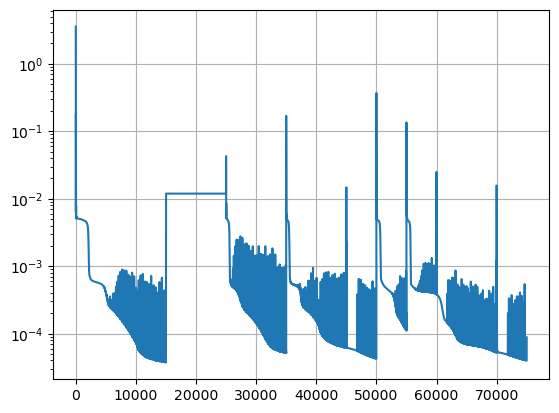

In [124]:
plt.semilogy(range(len(loss_values)), loss_values)
plt.grid()

# (Qualitative) evaluation of the trained deepONet

The following function computes the predicted values on some coefficients and the corresponding loss.

In [112]:
def evaluate_deeponet(model, x, coefs, solutions):
    model.eval()
    with torch.no_grad():
        u_pred = model(coefs.to(device), x.to(device))
        loss = criterion(u_pred, solutions.to(device))
        print(f'Loss: {loss.item():.4e}')
    return u_pred

We then plot the comparison on three random functions from the training set. Launching the code again will show (potentially) new functions.

Loss: 3.7793e-04
torch.Size([250, 64])


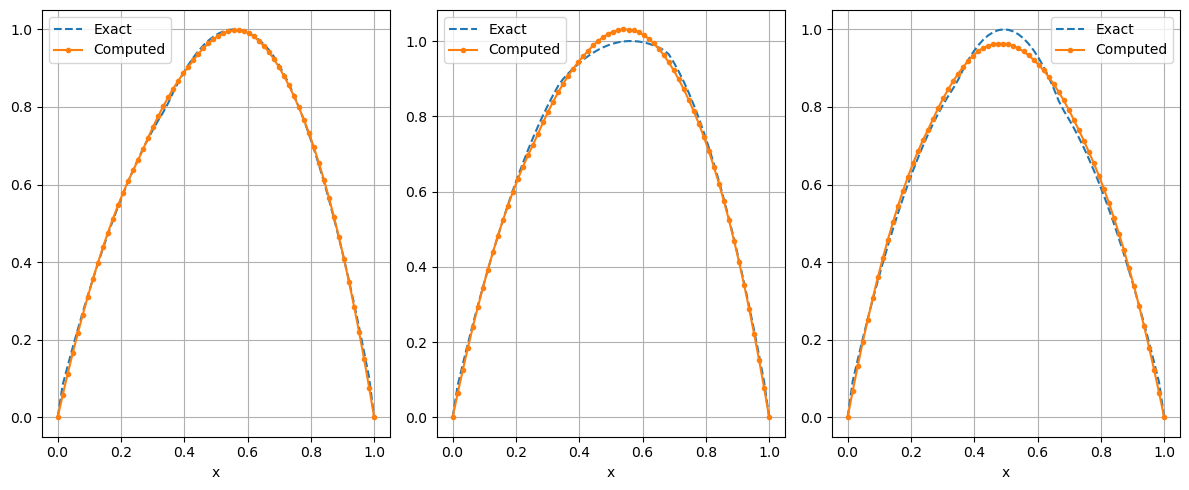

In [113]:
# Plot results
predicted_solutions = evaluate_deeponet(model, x, coefs, solutions)
print(solutions.shape)
plot_results(x.detach(), solutions, predicted_solutions.detach(), num_samples_to_plot=3)

We now do the same thing with the gradients, still comparing with functions in the training set.

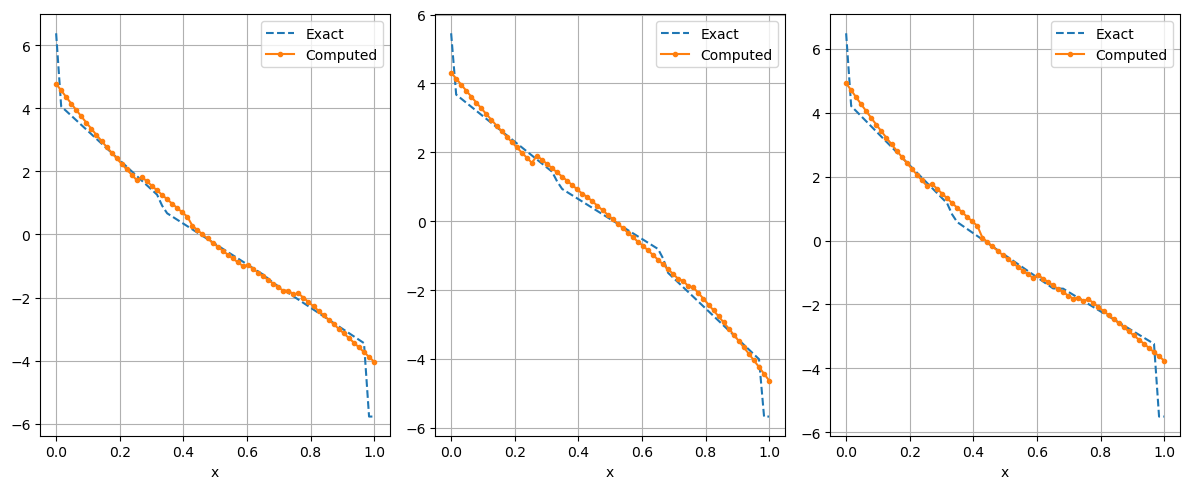

In [114]:
predicted_grads = model.grad_forward(coefs, x)
plot_results(x.detach(), grad_solutions, predicted_grads.detach(), num_samples_to_plot=3)

Finally, we look at the behaviour on new data, not contained in the training set. We start by loading the data

In [115]:
x_test = torch.load("data/x_test.pt")
coefs_test = torch.load("data/a_test.pt")
solutions_test = torch.load("data/u_test.pt")
grad_solutions_test = torch.load("data/gradu_test.pt")
# see the dimension of the data
print("Dimension of x: ", x_test.shape)
print("Dimension of coefs: ", coefs_test.shape)
print("Dimension of solutions: ", solutions_test.shape)
print("Dimension of solutions: ", grad_solutions_test.shape)

Dimension of x:  torch.Size([64])
Dimension of coefs:  torch.Size([500, 64])
Dimension of solutions:  torch.Size([500, 64])
Dimension of solutions:  torch.Size([500, 64])


Then compare function values (again, on three randomly chosen functions, this time in the test set)

Loss: 3.8377e-04


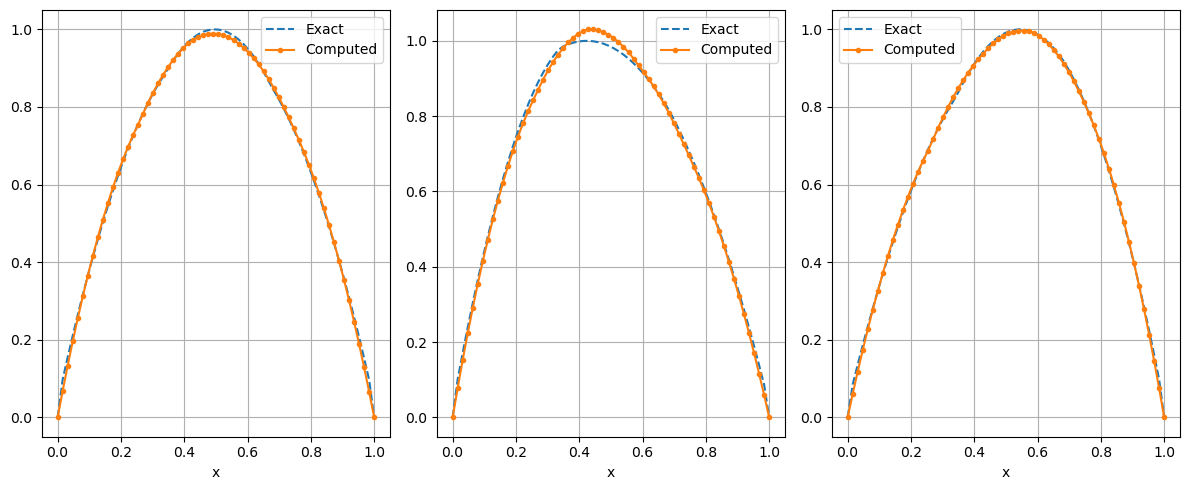

In [116]:

predicted_solutions_test = evaluate_deeponet(model, x_test, coefs_test, solutions_test)
plot_results(x_test.detach(), solutions_test, predicted_solutions_test.detach(), num_samples_to_plot=3)

And gradients:

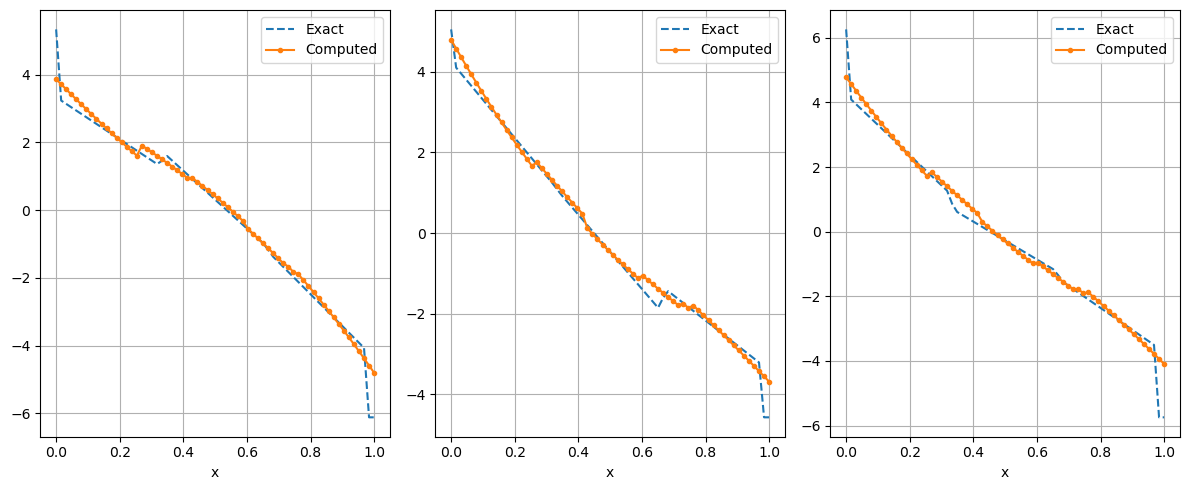

In [117]:
predicted_grads = model.grad_forward(coefs_test, x)
plot_results(x.detach(), grad_solutions_test, predicted_grads.detach(), num_samples_to_plot=3)